# Regression Analysis

This is a notebook to test out how different regression models compare on fitting various simple two-dimensional datasets. This comparison demonstrates how well these models fit the training data and shows how well (or poorly) the models can extrapolate their learned knowledge to test points outside the range of their training points.

Running options include printing a compact list of mean squared errors of each model and plotting each model on each dataset. The printing option shows the mean squared error of a test set completely within the bounds of the training set, one that extends 10% outside in each direction (positive and negative), one that extends 50% outside in each direction, and finally one that extends 100% beyond the original training set in each direction. The plotting method only plots test points within 100% of the bounds of the training set.

In [1]:
import math
import numpy as np
import random
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error as mse
import matplotlib.pyplot as plt

# User Definitions

A few high-level options to use this notebook

In [2]:
n_train_pts = 1000
n_test_pts = 100 # number of test points to gather from each test region

# a range of x values to use across all functions for training
### ranges should be chosen such that they are centered about 0
x_min = -10
x_max = 10

# how many iterations we're going to go through this process
# to average the results over the number of iterations
num_its = 2 

### make sure to fill this list out with the names of each of the functions you want to use
# these functions are completed below
dataset_list = ['linear', 'quadratic', 'absolute', 'sinusoid', 'exponential']

# Dataset Selection

We'll create a different function for each one of these. For each function, input an array of x values. It'll return the y array for that dataset. They'll all have the same x array. This will be put into a dictionary by a separate function

In [3]:
def linear(x):
    return x

def quadratic(x):
    return x**2

def absolute(x):
    return np.absolute(x)

def sinusoid(x):
    return np.sin(x)

def exponential(x):
    return np.exp(x)

In [4]:
### model selection

# create a dictionary to store all the models in
model_dict = {}

# list of models, with parameters
model_dict['XGB'] = GradientBoostingRegressor()
#model_dict['SupportVector'] = SVR()
model_dict['SupportVector_2'] = SVR(kernel='linear', C=100, epsilon=.001)
#model_dict['RandomForest'] = RandomForestRegressor()
#model_dict['ExtraTrees'] = ExtraTreesRegressor()
model_dict['AdaBoost'] = AdaBoostRegressor()
#model_dict['KNN'] = KNeighborsRegressor()
model_dict['NN'] = MLPRegressor()

### end model selection

In [5]:
# function to create the dataset dictionary
def trainset_creation():

    # create a numpy x array
    x = np.array([])
    for _ in range(n_train_pts):
        x = np.append(x, random.random()*(x_max - x_min) + x_min)

    # now create the dictionary to store the datasets
    trainset_dict = {}

    for dataset_name in dataset_list:

        exec('trainset_dict[dataset_name] = [x, {}(x)]'.format(dataset_name))

        #print(trainset_dict[dataset_name][0].shape, trainset_dict[dataset_name][1].shape)

    return trainset_dict

In [6]:
def testset_creation():

    # need to create the x ranges for all the types we need
    # maybe we'll split the number of points between the positive and negative sides
    # get equal numbers on each side

    # first, let's create the in_bounds x set
    x_in_bounds = np.array([])
    for _ in range(n_test_pts):
        x_in_bounds = np.append(x_in_bounds, random.random()*(x_max - x_min) + x_min)

    # now one for the 10% out of bounds
    # we'll need 2 sets of bounds. 
    # x_min_10 is 10% lower than x_min. x_min will be the upper bound of the lower range
    # x_max_10 is 10% higher than x_max. x_max will be the lower bound of the upper range
    x_min_10 = x_min - abs(x_min*0.1)
    x_max_10 = x_max + abs(x_max*0.1)

    # create the set for that
    x_10 = np.array([])

    # need to split this process in two
    for _ in range(int(n_test_pts/2)):
        x_10 = np.append(x_10, random.random()*(x_min - x_min_10) + x_min_10)
    for _ in range(int(n_test_pts/2)):
        x_10 = np.append(x_10, random.random()*(x_max_10 - x_max) + x_max)

    # cool, now repeat the process for 50%
    x_min_50 = x_min - abs(x_min*0.5)
    x_max_50 = x_max + abs(x_max*0.5)
    x_50 = np.array([])
    for _ in range(int(n_test_pts/2)):
        x_50 = np.append(x_50, random.random()*(x_min - x_min_50) + x_min_50)
    for _ in range(int(n_test_pts/2)):
        x_50 = np.append(x_50, random.random()*(x_max_50 - x_max) + x_max)

    # and 100
    x_min_100 = 2*x_min
    x_max_100 = 2*x_max 
    x_100 = np.array([])
    for _ in range(int(n_test_pts/2)):
        x_100 = np.append(x_100, random.random()*(x_min - x_min_100) + x_min_100)
    for _ in range(int(n_test_pts/2)):
        x_100 = np.append(x_100, random.random()*(x_max_10 - x_max) + x_max)

    # cool, now that we have all the x sets for testing, we need to create the y sets and dictionize
    testset_dict = {}

    for dataset_name in dataset_list:

        # no easy loop for this, sorry
        #dict_in_bounds = {}
        dataset_temp_dict = {}
        exec('dataset_temp_dict[\'in_bounds\'] = [x_in_bounds, {}(x_in_bounds)]'.format(dataset_name))

        #dict_10 = {}
        exec('dataset_temp_dict[\'10_percent_out\'] = [x_10, {}(x_10)]'.format(dataset_name))

        #dict_50 = {}
        exec('dataset_temp_dict[\'50_percent_out\'] = [x_50, {}(x_50)]'.format(dataset_name))

        #dict_100 = {}
        exec('dataset_temp_dict[\'100_percent_out\'] = [x_100, {}(x_100)]'.format(dataset_name))

        testset_dict[dataset_name] = dataset_temp_dict

    return testset_dict

In [7]:
def train_test_models(trainset_dict, testset_dict):

    # create a dictionary for the results
    result_dict = {}

    # so we need to loop through all the models
    for model_name in model_dict.keys():

        print(' Training model {}'.format(model_name))

        # pull out the model
        model = model_dict[model_name]

        # create a dictionary for the model
        model_result_dict = {}

        # then loop through each of the training sets
        for dataset_name in trainset_dict.keys():

            # helpful print
            #print('Training {} on {} dataset'.format(model_name, dataset_name))

            # then you get to train on this dataset!
            
            x_train, y_train = trainset_dict[dataset_name]

            # train the model
            model = model.fit(x_train.reshape(-1,1), y_train)

            # create a dictionary for the results
            dataset_result_dict = {}

            # then evaluate on the four sets
            x_test, y_test = testset_dict[dataset_name]['in_bounds']
            dataset_result_dict['in_bounds'] = mse(y_test, model.predict(x_test.reshape(-1,1)))

            x_test, y_test = testset_dict[dataset_name]['10_percent_out']
            dataset_result_dict['10_percent_out'] = mse(y_test, model.predict(x_test.reshape(-1,1)))

            x_test, y_test = testset_dict[dataset_name]['50_percent_out']
            dataset_result_dict['50_percent_out'] = mse(y_test, model.predict(x_test.reshape(-1,1)))

            x_test, y_test = testset_dict[dataset_name]['100_percent_out']
            dataset_result_dict['100_percent_out'] = mse(y_test, model.predict(x_test.reshape(-1,1)))

            # then add this dictionary to model_result_dict
            model_result_dict[dataset_name] = dataset_result_dict

        # add the model result dict to the overall result dict
        result_dict[model_name] = model_result_dict

    # then return the result_dict
    return result_dict

In [8]:
# then we need a function to print out all this stuff
def print_results(result_dict):

    # loop through the model names
    for model_name in result_dict.keys():

        print('--- {} ---'.format(model_name))

        model_result_dict = result_dict[model_name]

        # loop through the dataset names
        for dataset_name in model_result_dict.keys():

            print(' {}:'.format(dataset_name))

            # then pull out the dictionary for that
            dataset_result_dict = model_result_dict[dataset_name]

            print('    In-bounds: {}'.format(dataset_result_dict['in_bounds']))
            print('    10 percent outside: {}'.format(dataset_result_dict['10_percent_out']))
            print('    50 percent outside: {}'.format(dataset_result_dict['50_percent_out']))
            print('    100 percent outside: {}'.format(dataset_result_dict['100_percent_out']))

In [9]:
def plot_model(model_name, dataset_name):

    # so first we need to create the x dataset
    
    #####
    # WE NEED TO CHANGE THIS TO A SPECIFIC NUMBER OF POINTS??
    #####
    x_train = np.arange(x_min, x_max, .001).reshape(-1,1)
    x_test = np.arange(2*x_min, 2*x_max, .001).reshape(-1,1)

    temp_array = []
    exec('temp_array.append({}(x_train))'.format(dataset_name))
    exec('temp_array.append({}(x_test))'.format(dataset_name))
    y_train = temp_array[0]
    y_test = temp_array[1]
    

    # now train the model and get the predictions
    model = model_dict[model_name].fit(x_train, y_train)

    # predict
    y_pred = model.predict(x_test)

    # so we want to plot x_test vs. y_test
    # as well as x_test vs. y_pred
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.scatter(x_test, y_test, s=10, c='b', marker="s", label=dataset_name)
    ax1.scatter(x_test, y_pred, s=10, c='r', marker="o", label=model_name)

    plt.legend(loc='upper left')
    
    # then finally calculate the error, round to 5 decimal places, place in title with the name
    plt.title('{} | 100 percent outside on {}: {}'.format(model_name, dataset_name, round(mse(y_test, y_pred), 5)))
    plt.show()
    

In [10]:
def detailed_errors_with_multiple_its():

    
    result_dict = {}

    for i in range(num_its):

        print('Iteration {}'.format(i + 1))

        trainset_dict = trainset_creation()
        testset_dict = testset_creation()
        temp_result_dict = train_test_models(trainset_dict, testset_dict)

        if i == 0:

            result_dict = temp_result_dict

        else:

            for model_name in result_dict.keys():
                for dataset_name in result_dict[model_name].keys():
                    for tier in result_dict[model_name][dataset_name].keys():
                        result_dict[model_name][dataset_name][tier] += temp_result_dict[model_name][dataset_name][tier]

    # then divide the results out
    for model_name in result_dict.keys():
        for dataset_name in result_dict[model_name].keys():
            for tier in result_dict[model_name][dataset_name].keys():
                result_dict[model_name][dataset_name][tier] /= num_its


    print_results(result_dict)
    
    
    


In [ ]:
def errors_and_plots_100_percent():
    
    for dataset_name in dataset_list:
        for model_name in model_dict.keys():
            plot_model(model_name, dataset_name)
    

/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


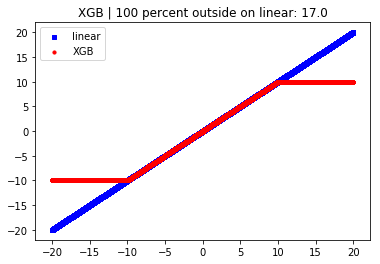

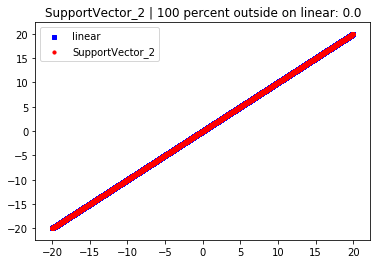

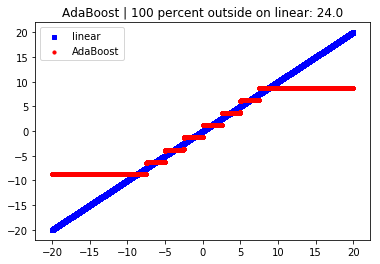

/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:1306: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


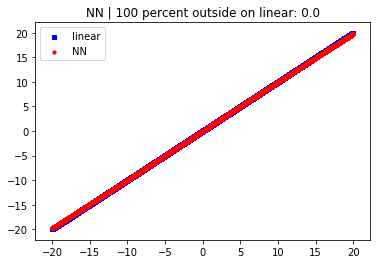

/Users/michael/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


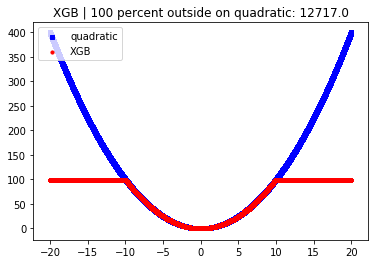

KeyboardInterrupt: 

In [ ]:
errors_and_plots_100_percent()